## In-Class Assignment: Diagnosing Bias and Variance

Use the [CDC Diabetes Health Indicators](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators) dataset to explore how to diagnose bias and variance.

In [1]:
pip install -q ucimlrepo

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
from ucimlrepo import fetch_ucirepo

cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

In [4]:
X.max()

HighBP                   1
HighChol                 1
CholCheck                1
BMI                     98
Smoker                   1
Stroke                   1
HeartDiseaseorAttack     1
PhysActivity             1
Fruits                   1
Veggies                  1
HvyAlcoholConsump        1
AnyHealthcare            1
NoDocbcCost              1
GenHlth                  5
MentHlth                30
PhysHlth                30
DiffWalk                 1
Sex                      1
Age                     13
Education                6
Income                   8
dtype: int64

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

ct = make_column_transformer(
    (StandardScaler(), ['BMI','MentHlth','PhysHlth']),
    (OneHotEncoder(), ['Age', 'Education', 'Income','GenHlth']),
    (OrdinalEncoder(), ['HighBP','HighChol','CholCheck','Smoker','Stroke','HeartDiseaseorAttack','PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','DiffWalk','Sex']),
    remainder="drop"
)

We will fit the column transformer on all the data first, because we run into issues when we fit it on a subsample of the data and then evaluate on the entire test set.

In [6]:
ct.fit(X)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['BMI', 'MentHlth', 'PhysHlth']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Age', 'Education', 'Income', 'GenHlth']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['HighBP', 'HighChol', 'CholCheck', 'Smoker',
                                  'Stroke', 'HeartDiseaseorAttack',
                                  'PhysActivity', 'Fruits', 'Veggies',
                                  'HvyAlcoholConsump', 'AnyHealthcare',
                                  'NoDocbcCost', 'DiffWalk', 'Sex'])])

In [7]:
X_train = X.sample(frac=0.8,random_state=1234)
y_train = y.loc[X_train.index]['Diabetes_binary']

X_test = X.drop(X_train.index)
y_test = y.drop(X_train.index)['Diabetes_binary']

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

Here's an example of how to subsample the training set to 1000 rows, train a model on it, and calculate accuracy.    Note that the error rate would be 1-accuracy.

Our target is 95% accuracy (5% error rate).

In [9]:
X_train_small = X_train.sample(1000,random_state=1234)
y_train_small = y_train.loc[X_train_small.index]

model = LogisticRegression(max_iter=1000)
model.fit(ct.transform(X_train_small),y_train_small)

accuracy = accuracy_score(y_train_small,model.predict(ct.transform(X_train_small)))

Create a plot of test set error as we increase the training set size from 1,000 to 50,000 examples.

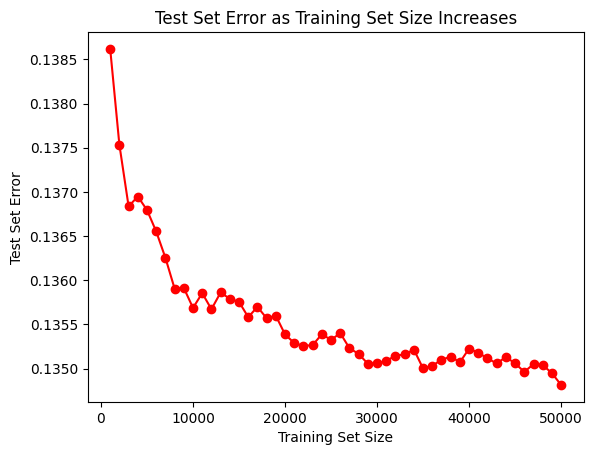

In [10]:
sizes = np.arange(1000, 51000, 1000)
errors = []
for size in sizes:
  X_train_set = X_train.sample(size, random_state=1234)
  y_train_set = y_train.loc[X_train_set.index]
  X_test_set = X.drop(X_train_set.index)
  y_test_set = y.drop(X_train_set.index)['Diabetes_binary']

  model = LogisticRegression(max_iter=1000)
  model.fit(ct.transform(X_train_set), y_train_set)

  acc = accuracy_score(y_test_set, model.predict(ct.transform(X_test_set)))
  error = 1 - acc
  errors.append(error)

plt.plot(sizes, errors, color='red', marker='o', linestyle='-')
plt.xlabel('Training Set Size')
plt.ylabel('Test Set Error')
plt.title('Test Set Error as Training Set Size Increases')
plt.show()

Create a plot of both train and test set error as the training set size increases from 1,000 to 50,000 examples.

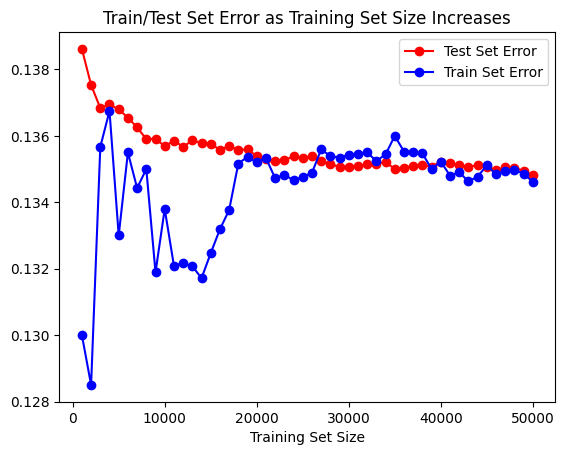

In [11]:
sizes = np.arange(1000, 51000, 1000)
train_errors = []
test_errors = []
for size in sizes:
  X_train_set = X_train.sample(size, random_state=1234)
  y_train_set = y_train.loc[X_train_set.index]
  X_test_set = X.drop(X_train_set.index)
  y_test_set = y.drop(X_train_set.index)['Diabetes_binary']

  model = LogisticRegression(max_iter=1000)
  model.fit(ct.transform(X_train_set), y_train_set)

  train_acc = accuracy_score(y_train_set, model.predict(ct.transform(X_train_set)))
  train_error = 1 - train_acc
  train_errors.append(train_error)

  test_acc = accuracy_score(y_test_set, model.predict(ct.transform(X_test_set)))
  test_error = 1 - test_acc
  test_errors.append(test_error)

plt.plot(sizes, test_errors, color='red', marker='o', linestyle='-', label='Test Set Error')
plt.plot(sizes, train_errors, color='blue', marker='o', linestyle='-', label='Train Set Error')
plt.xlabel('Training Set Size')
plt.title('Train/Test Set Error as Training Set Size Increases')
plt.legend()
plt.show()

Analyze the performance of the model and give a recommendation for how to proceed.

In this case, we seem to have a problem of high bias and low variance. Thus, I we should try improving the model and/or applying feature engineering.